# Exploration and visualization of our collected metrics 
In this notebook, we will read the collected metrics from ceph and uses interactive widgets to explore and visualize our data.

In [1]:
# !pip install fsspec s3fs

In [ ]:
import os
import ipywidgets as widgets
from functools import partial

from matplotlib import pyplot as plt
import seaborn as sns

from ipynb.fs.defs.metric_template import CephCommunication

from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [2]:
## Specify variables

## CEPH Bucket variables
## Create a .env file on your local with the correct configs
s3_endpoint_url = os.getenv(
    "S3_ENDPOINT", "https://s3-openshift-storage.apps.zero.massopen.cloud/"
)
s3_access_key = os.getenv("S3_ACCESS_KEY", "v3FnruQ78kfeULDjejUB")
s3_secret_key = os.getenv("S3_SECRET_KEY", "kJiDiHXncLJOXbaL7Zeb5Ok+gkLt9sWIa1rWAJa0")
s3_bucket = os.getenv("S3_BUCKET", "opf-datacatalog")
s3_path = os.getenv("S3_PROJECT_KEY", "metrics")

# Specify whether or not we are running this as a notebook or part of an automation pipeline.
AUTOMATION = os.getenv("IN_AUTOMATION", True)

In [3]:
# ceph connector
metric_select = "number_of_flakes-2021"
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)

# bucket where the KPI metrics are stored
metrics_bucket = cc.s3_resource.Bucket(s3_bucket)

# get all objects (files) corresponding to all metrics
# FIXME: ideally these should be the ones beginning with the metrics prefix, and not all parquets
# available_metrics = metrics_bucket.objects.filter(Prefix=s3_path)
available_metric_objs = [o for o in metrics_bucket.objects.all() if metric_select in o.key]

for i in available_metric_objs:
    print(i)

s3.ObjectSummary(bucket_name='opf-datacatalog', key='metrics/number_of_flakes/number_of_flakes-2021-4-14.parquet')
s3.ObjectSummary(bucket_name='opf-datacatalog', key='metrics/number_of_flakes/number_of_flakes-2021-4-16.parquet')
s3.ObjectSummary(bucket_name='opf-datacatalog', key='metrics/number_of_flakes/number_of_flakes-2021-4-19.parquet')


In [4]:
# extract the names of unique KPI metric files, and the KPIs available in them
METRIC_NAME = "number_of_flakes"
metric_path = f"metrics/{METRIC_NAME}/"
kpis_in_metric_objs = dict()

for o in available_metric_objs:
    if o not in kpis_in_metric_objs:
        # read a sample file to see what kpis are contained in this file
        prefix, folder, key = o.key.split("/")
        # FIXME: Ideally prefix will always be "metrics" but rn it isnt so manually set it
        sample_file = cc.read_from_ceph(metric_path, "number_of_flakes-2021-4-14.parquet")

        # get these kpis names
        kpis = sample_file.columns.drop(
            ["timestamp", "tab", "grid", "test"], errors="ignore" #this drops possible useful columns
                                                                # ie, using 'test' to select only overall
        ).tolist()

        # update mapping of "filename": "kpi"
        kpis_in_metric_objs[key.split(".")[0]] = kpis

kpis_in_metric_objs

ClientError: An error occurred (404) when calling the HeadObject operation: Not Found

In [5]:
# select metric objects and the kpis in them to visualize
def on_metric_obj_selected(metric_obj, kpis_widget=None):
    new_opts = []
    for selected_obj in metric_obj.new:
        new_opts += kpis_in_metric_objs[selected_obj]
    kpis_widget.options = new_opts


metric_obj_widget = widgets.SelectMultiple(
    options=kpis_in_metric_objs.keys(), disabled=False
)

kpis_widget = widgets.SelectMultiple(options=[], disabled=False)

metric_obj_widget.observe(
    partial(on_metric_obj_selected, kpis_widget=kpis_widget),
    "value",
)

display(metric_obj_widget)
display(kpis_widget)

SelectMultiple(options=(), value=())

SelectMultiple(options=(), value=())

In [6]:
metric_obj_widget.value, kpis_widget.value

((), ())

## todo
- right now this will fail for some cases because not all metrics are under "metrics" prefix (see https://github.com/aicoe-aiops/ocp-ci-analysis/issues/217#issuecomment-819624029)
- need to know what columns exist in which df when indexing
- some dfs have a column "grid" vs some others have "job"?

In [7]:
# read one of the kpis to plot the selected metrics objects from ceph
metric = cc.read_from_ceph(s3_path, f"{metric_obj_widget.value[1]}.parquet")
metric[["timestamp", "tab", "grid", "test"] + [kpis_widget.value[1]]].head()

IndexError: tuple index out of range

## Next step 1

assuming there is a metric df that looks like above, plot something like this:

Given a dashboard (e.g. "redhat-openshift-ocp-release-4.6-informing”), plot the `Overall` KPI values for jobs within the dashboard (e.g. plot the Overall test duration for “periodic-ci-openshift-release-master-ci-4.6-e2e-aws” vs “periodic-ci-openshift-release-master-ci-4.6-e2e-gcp” vs …)

In [8]:
METRIC_NAME = "number_of_flakes"
metric_path = f"metrics/{METRIC_NAME}"
metric = cc.read_from_ceph(metric_path, "number_of_flakes-2021-4-14.parquet")


In [9]:
overall_metric = metric[metric['test'] == "Overall"]
overall_metric = metric[metric['timestamp'] >= "2021-03-01 00:00:00"]
overall_metric.head()

,timestamp,tab,grid,test,test_duration,flake
0,2021-04-14 16:12:04,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,105.583333,False
1,2021-04-14 15:05:09,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,87.216667,False
2,2021-04-14 13:13:36,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,99.100000,False
3,2021-04-14 02:02:46,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,107.316667,False
4,2021-04-13 19:12:42,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,85.583333,False


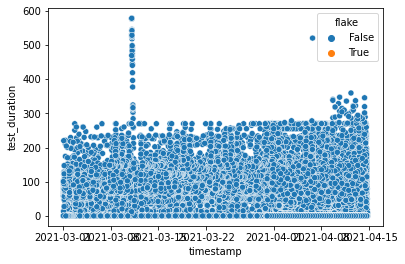

In [10]:
sns.scatterplot(x="timestamp", y="test_duration", \
            hue="flake", data=overall_metric)
plt.show()

In [11]:
flake_button = widgets.RadioButtons(
    options=['True', 'False'],
    value='False', # Defaults to 'pineapple'
    description='Flake:',
    disabled=False
)
display(flake_button)

RadioButtons(description='Flake:', index=1, options=('True', 'False'), value='False')

In [12]:
def interact_plot(var):
    sns.scatterplot(x="timestamp", y="test_duration", \
            hue=var, data=overall_metric)
    plt.show()
    
widgets.interact(interact_plot, \
                 var = widgets.RadioButtons(\
                                      options=['True', 'False'], \
                                      value='False', \
                                      description='Flake:',\
                                      disabled=False)
                )


interactive(children=(RadioButtons(description='Flake:', index=1, options=('True', 'False'), value='False'), O…

<function __main__.interact_plot(var)>

## Next step 2

assuming there is a metric df that looks like above, plot something like this:

Given a job (e.g. “periodic-ci-openshift-release-master-ci-4.6-e2e-gcp”), plot the KPI values for tests within the job (e.g. plot duration for “operator conditions cloud-credential” vs “operator conditions cluster-autoscaler” vs ...)

In [ ]:
def plot_builds_tab_grid(tab, job, df, metric_name):

    """
    Takes in input as tab and grid and plots change in
    build pass/fail over time
    """

    df = df[(df["tab"] == tab) | (df["job"] == job)]

    sns.set(rc={"figure.figsize": (15, 5)})
    sns.lineplot(x="timestamp", y=metric_name, data=df)
    plt.xlabel("Timestamps")
    plt.ylabel(metric_name)
    plt.title("Change in Build Pass or Failure over time")
    plt.show()

In [ ]:
plot_builds_tab_grid(
    "redhat-openshift-informing",
    "release-openshift-okd-installer-e2e-aws-upgrade",
    metric,
    "test_duration",
)

In [ ]:
plot_builds_tab_grid(
    "redhat-openshift-informing",
    "release-openshift-okd-installer-e2e-aws-upgrade",
    metric,
    "build_status",
)